<p align="center">
    <img 
        src="https://raw.githubusercontent.com/Empa-Teknoloji/AI_Workshop_GU/master/Activity2_NEAIS_for_EdgeAI_Solutions_and_Deployment/Additionals/Empa-Accelerator-Workshops-Template-Banner.jpg" 
        alt="Accelerator Workshops" 
        style="display: block; margin: 0 auto" 
        height=600/>
</p>

# 1) Vitis-AI ile FPGA Platformlarında AI Uygulamaları Geliştirme
Empa Electronics tarafından düzenlenen Accelerators Workshops serimizin "Gazi Üniversitesi Uçta Yapay Zeka Çalıştayı" adımına hoşgeldiniz.  
Bu kılavuz, modern makine öğrenimi yaklaşımlarıyla geliştirilmiş bir yapay zeka/derin öğrenme çözümünün Vitis-AI geliştirme ortamı araçları kullanılarak FPGA tabanlı platformlara implementasyonu adımlarının deneyimlenmesinde size rehberlik edecektir.

Aktivite içeriği olan "YOLOV5 Derin Öğrenme Mimarisi İle Nesne Tespiti" uygulamasının adımları, AMD'nin Kria ürün serisine ait KV260 geliştirme kartı üzerinde adımlarla açıklanacaktır. Kullanılan model mimarisi, kart üzerindeki FPGA yapısı bloğu için AMD tarafından tasarlanmış DPU IP desteğiyle çalıştırılacak ve Vitis-AI ortamı araçları yardımıyla yapay zeka çözümü haline getirilecektir.

**Uygulama Adımları**

1- Modelin Değerlendirilmesi & Ön Tanımlamalar  

2- Vitis-AI DPU Desteği İçin Model Modifikasyonu  

3- Modifikasyon ve Eğitim Sonrası Model  

4- Modelin Doğrulanması (Inspection + Prediction)  

5- Modifikasyon Sonrası Gereksinimler

6- Post-processing ve Tahminlerin Eldesi

7- Model Quantization Adımı

8- Modelin Hedef Platform İçin Derlenmesi

## 1. Modelin Değerlendirilmesi & Ön Tanımlamalar

### 1.1. Gerekli modüllerin dahil edilmesi

In [1]:
!pip install torchinfo

import torch
import cv2
import numpy as np
from models.common import DetectMultiBackend
from PIL import Image

### 1.2. Ön Tanımlamalar

In [2]:
# Hedef mimari kimlik versiyonu (DPU IP version)
target_architecture = "DPUCZDX8G_ISA1_B4096"
# orijinal model dosya yolu
path_model_original = "/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/yolov5s_original.pt"
# düzenlenmiş model dosya yolu
path_model_modified = "/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/yolov5s_trained.pt"
# örnek girdi dosya yolu
path_image_original = "/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/data/images/zidane.jpg"

# Pytorch için cihaz tanılaması
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# örnek girdi için boyut değerleri
IMG_SIZE = (540, 960)
# örnek girdi görüntü kanalı adedi
IMG_CHANNELS = 3

### 1.3. Yardımcı Fonksiyonlar

Yardımcı Fonksiyon: Model Yükleyici

In [3]:
def import_model(path_model, device_type):
    device = torch.device(device_type)
    model = DetectMultiBackend(weights=path_model, device=device)
    return model

Yardımcı Fonksiyon: Model Inspector çalıştırıcı

In [4]:
def inspect_model(model, device, image_shape, outdir):
    # import model inspector
    from pytorch_nndct import Inspector
    
    # define a dummy input
    c, h, w = image_shape
    input_dummy = torch.randn(1, c, w, h).to(device)
    device = torch.device(device)

    inspector = Inspector(target_architecture)
    inspector.inspect(model, (input_dummy,), device=device, output_dir=outdir, image_format="png")

Yardımcı Fonksiyon: Model İle Tahminleme

In [5]:
augment = False
visualize = False

def execute_model(model, img):
    from torchvision.transforms import Compose, ToTensor, Resize

    transforms = Compose([
        ToTensor(),
        Resize(size=(540, 960)), 
    ])

    img = transforms(img)
    img = img.unsqueeze(0).cuda()

    pred = model(img, augment=augment, visualize = visualize)
    return pred

Yardımcı Fonksiyon: Model Sonuçları (Tahminleri) Görselleştirici

In [6]:
def draw_bbox(image, preds_nms):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (960, 540))
    
    for ind, pred in enumerate(preds_nms):
        topleft = (int(pred[0]), int(pred[1]))
        bottomright = (int(pred[2]), int(pred[3]))
        print(f"Object instance: {ind} | topleft: {topleft}, bottomright: {bottomright}")
        
        cv2.rectangle(image, topleft, bottomright, (255, 0, 0), 2)

    image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
    return image

### 1.4. Tahminleme İçin Örnek Veri

Tahminleme için kullanılacak veri örneği (_Kaynak: Ultralytics GitHub_):

In [7]:
img_original = Image.open(path_image_original)

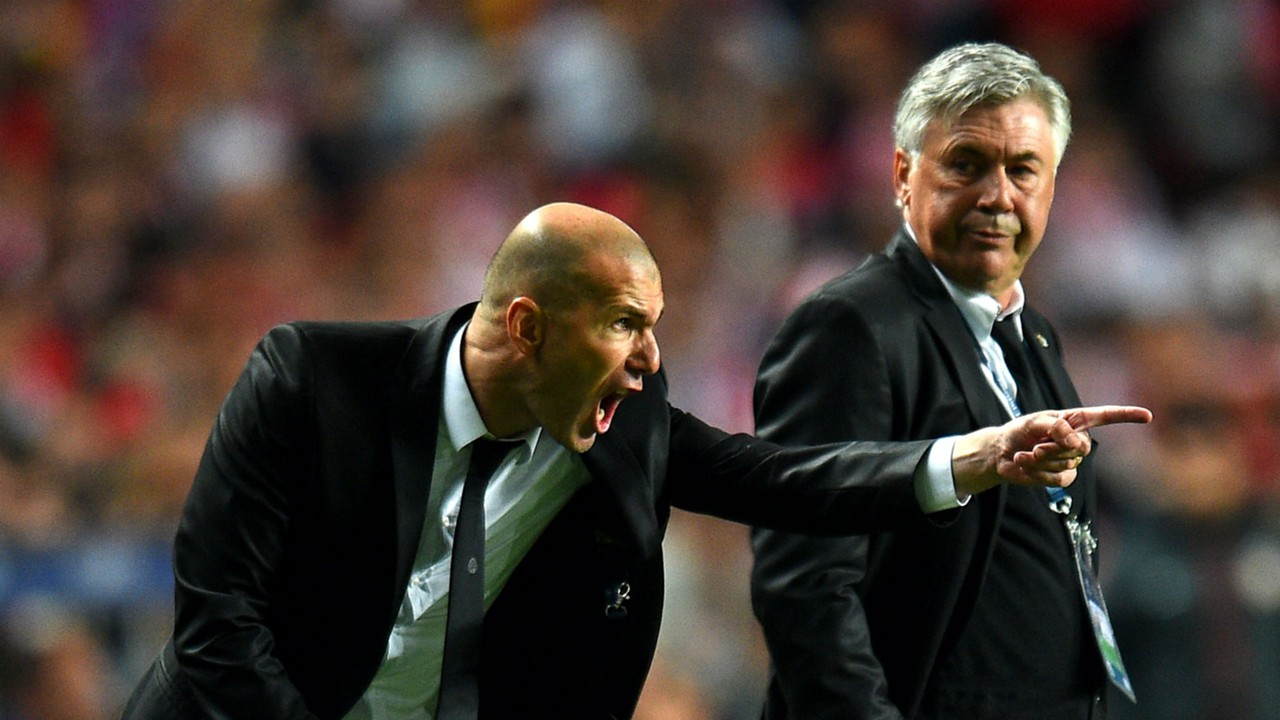

In [8]:
img_original

### 1.4. Modelin Değerlendirilmesi

Orijinal modelin yüklenmesi:

In [20]:
model_original = import_model(path_model_original, DEVICE)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


(ÇALIŞTIRILMAYACAK) Orijinal modelin analizi:

In [8]:
# inspect_model(model_original, DEVICE, (IMG_CHANNELS, IMG_SIZE[0], IMG_SIZE[1]), 
#               outdir="/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/inspection_results_original")


[VAIQ_NOTE]: Loading NNDCT kernels...

[VAIQ_NOTE]: Inspector is on.

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing DetectMultiBackend...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_DetectMultiBackend_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 253/253 [00:00<00:00, 896.79it/s, OpInfo: name = return_0, type = Return]                                                                                                                   


[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::pow` as a float operator by default.



[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::meshgrid` as a float operator by default.

[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `nndct_expand` as a float operator by default.

[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::silu_` as a float operator by default.

[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `nndct_stack` as a float operator by default.

[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `nndct_select` as a float operator by default.

[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/inspection_results_original/DetectMultiBackend.py)

[VAIQ_WARN]: DetectMultiBackend::14843 is not tensor.

[VAIQ_WARN]: DetectMultiBackend::14849 is not tensor.

[VAIQ_WARN]: DetectMultiBackend::14852 is not tensor.

[VAIQ_

I20241220 01:26:47.281479 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:47.281500 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:47.281507 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:47.281610 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_permute_gnvXcsMzyFSi3A8w, with op num: 4
I20241220 01:26:47.281613 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
W20241220 01:26:47.284703 67815 PartitionPass.cpp:4160] [UNILOG][WARNING] xir::Op{name = DetectMultiBackend__DetectMultiBackend_DetectionModel_model__C3_model__C3_6__Sequential_m__Bottleneck_0__Conv_cv2__Conv2d_conv__ret_49_sink_transpose_18, type = transpose} has been assigned to CPU.
I20241220 01:26:47.284824 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 2, DPU subgraph number 0
I20241220 01:26:47.284845 67815 compile_p


[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Conv[cv1]/Conv2d[conv]/ret.99_sink_transpose_34, op type:nndct_permute, output shape: [1, 128, 60, 34]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/15667, op type:nndct_reshape, output shape: [1, 3, 1, 1, 2]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv2]/SiLU[act]/13620_swim_transpose_5, op type:nndct_permute, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[23]/Sequential[m]/Bottleneck[0]/Conv[cv1]/SiLU[act]/14754_swim_transpose_66, op type:nndct_permute, output shape: [1, 30, 17, 256]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name

I20241220 01:26:47.491606 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:47.491629 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:47.491633 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:47.491715 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_permute_82ze47gktB5ZEFbP, with op num: 4
I20241220 01:26:47.491720 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
W20241220 01:26:47.493788 67815 PartitionPass.cpp:4160] [UNILOG][WARNING] xir::Op{name = DetectMultiBackend__DetectMultiBackend_DetectionModel_model__C3_model__C3_20__Conv_cv1__Conv2d_conv__ret_133_sink_transpose_46, type = transpose} has been assigned to CPU.
I20241220 01:26:47.493880 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 2, DPU subgraph number 0
I20241220 01:26:47.493899 67815 compile_pass_manager.cpp:504] [UNIL


[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[14]/SiLU[act]/14434_swim_transpose_57, op type:nndct_permute, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv1]/Conv2d[conv]/ret.73_sink_transpose_26, op type:nndct_permute, output shape: [1, 256, 30, 17]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/SPPF[model]/SPPF[9]/Conv[cv2]/Conv2d[conv]/ret.91_sink_transpose_32, op type:nndct_permute, output shape: [1, 512, 30, 17]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[0]/Conv[cv1]/Conv2d[conv]/ret.25_sink_transpose_9, op type:nndct_permute, output shape: [1, 64, 120, 68]



[VAIQ_NOTE]: Find sub

I20241220 01:26:47.703373 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:47.703397 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:47.703401 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:47.703473 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_permute_ELr5MoSO4gHtnvb9, with op num: 4
I20241220 01:26:47.703480 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
W20241220 01:26:47.706607 67815 PartitionPass.cpp:4160] [UNILOG][WARNING] xir::Op{name = DetectMultiBackend__DetectMultiBackend_DetectionModel_model__C3_model__C3_20__Sequential_m__Bottleneck_0__Conv_cv2__Conv2d_conv__ret_137_sink_transpose_48, type = transpose} has been assigned to CPU.
I20241220 01:26:47.706734 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 2, DPU subgraph number 0
I20241220 01:26:47.706766 67815 compile


[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Sequential[m]/Bottleneck[0]/Conv[cv1]/Conv2d[conv]/ret.75_sink_transpose_27, op type:nndct_permute, output shape: [1, 256, 30, 17]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[23]/Conv[cv2]/Conv2d[conv]/ret.155_sink_transpose_55, op type:nndct_permute, output shape: [1, 256, 30, 17]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[0]/Conv[cv2]/SiLU[act]/13729_swim_transpose_13, op type:nndct_permute, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: Find subgraph for reshape_fix_1:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[0]/SiLU[act]/13512_swim_transpose_0, op type:nndct_permute, output shape: [1, 480, 270, 32]




I20241220 01:26:47.906478 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:47.906538 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_permute_hOMw2JjpWSiQ7KyU, with op num: 4
I20241220 01:26:47.906543 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
W20241220 01:26:47.908445 67815 PartitionPass.cpp:4160] [UNILOG][WARNING] xir::Op{name = DetectMultiBackend__DetectMultiBackend_DetectionModel_model__C3_model__C3_23__Conv_cv2__SiLU_act__14796_swim_transpose_68, type = transpose} has been assigned to CPU.
I20241220 01:26:47.908526 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 2, DPU subgraph number 0
I20241220 01:26:47.908546 67815 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 01:26:47.911073 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:47.911091 67815 compile_pass_manager.cpp:353] [UNILOG][INFO


[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/ret.273, op type:nndct_concat, output shape: [1, 3, 30, 17, 85]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[23]/ret.157, op type:nndct_concat, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/ret.83, op type:nndct_concat, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Concat[model]/Concat[16]/ret.115, op type:nndct_concat, output shape: [1, 120, 68, 256]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/ret, op type:nndct_concat, output shape: [1,

I20241220 01:26:48.108578 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.108582 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:48.108633 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_concat_RaS5VBfdW7bN4jCp, with op num: 6
I20241220 01:26:48.108637 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 01:26:48.111006 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
I20241220 01:26:48.111034 67815 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 01:26:48.114997 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:48.115041 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.115046 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:48.115190


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Conv[cv1]/Conv2d[conv]/ret.133, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[2]/Conv[cv2]/Conv2d[conv]/ret.61, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/Conv2d[m]/ModuleList[2]/ret.241, op type:nndct_conv2d, output shape: [1, 30, 17, 255]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[1]/Conv[cv2]/Conv2d[conv]/ret.55, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fi

I20241220 01:26:48.290035 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_Lq1kyPdbf64HKh25, with op num: 8
I20241220 01:26:48.290040 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 01:26:48.314271 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 01:26:48.314328 67815 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 01:26:48.318316 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:48.318364 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.318370 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:48.318542 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_vCcSKdpTDtobeUmV, with op num: 8
I20241220 01:26:48.318548 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.11, op type:nndct_conv2d, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv2]/Conv2d[conv]/ret.15, op type:nndct_conv2d, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.103, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[3]/Conv2d[conv]/ret.21, op type:nndct_conv2d, output shape: [1, 120, 68, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node nam

I20241220 01:26:48.517153 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:48.517164 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.517167 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:48.517213 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_vP1UmkdVS9swixeL, with op num: 8
I20241220 01:26:48.517217 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 01:26:48.521425 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 01:26:48.521446 67815 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 01:26:48.524690 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:48.524713 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.524717 67815 compile_pass_mana


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[2]/Conv[cv1]/Conv2d[conv]/ret.59, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Conv[cv3]/Conv2d[conv]/ret.41, op type:nndct_conv2d, output shape: [1, 120, 68, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Conv[cv1]/Conv2d[conv]/ret.99, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Conv[cv2]/Conv2d[conv]/ret.139, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::D

I20241220 01:26:48.714519 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_E0FDRhvbO2MlqW6g, with op num: 8
I20241220 01:26:48.714524 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 01:26:48.721709 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 01:26:48.721762 67815 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 01:26:48.728873 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:48.728888 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.728892 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:48.728947 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_ryaiYX8nFE7xJvqO, with op num: 8
I20241220 01:26:48.728951 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv3]/Conv2d[conv]/ret.85, op type:nndct_conv2d, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Conv[cv3]/Conv2d[conv]/ret.143, op type:nndct_conv2d, output shape: [1, 60, 34, 256]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[10]/Conv2d[conv]/ret.93, op type:nndct_conv2d, output shape: [1, 30, 17, 256]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.137, op type:nndct_conv2d, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::Detect

I20241220 01:26:48.919103 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.919106 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:48.919176 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_lcgtyRa4H8ZVK2Du, with op num: 8
I20241220 01:26:48.919180 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 01:26:48.927325 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 01:26:48.927378 67815 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 01:26:48.932480 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:48.932493 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:48.932497 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:48.932546


[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/ret.267, op type:nndct_elemwise_mul, output shape: [1, 3, 30, 17, 2]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/ret.187, op type:nndct_elemwise_mul, output shape: [1, 3, 120, 68, 2]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/16171, op type:nndct_elemwise_mul, output shape: [3, 2]



[VAIQ_WARN][QUANTIZER_TORCH_INSPECTOR_PATTERN]: The First dimension of pattern data node DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/15307's  shape is 3 > 1 which will be set to 1 temporarily for pattern matching.

[VAIQ_WARN][QUANTIZER_TORCH_INSPECTOR_PATTERN]: The First dimension of pattern data node DetectMultiBacken

I20241220 01:26:49.127055 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:49.127079 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:49.127103 67815 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 01:26:49.127175 67815 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_elemwise_mul_vrntZTNEUe10dyJf, with op num: 6
I20241220 01:26:49.127182 67815 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 01:26:49.134502 67815 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 01:26:49.134618 67815 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 01:26:49.138856 67815 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 01:26:49.138875 67815 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 01:26:49.138880 67815 compile_pas


[VAIQ_NOTE]: Dot image is generated.(/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/inspection_results_original/inspect_DPUCZDX8G_ISA1_B4096.png)

[VAIQ_NOTE]: =>Finish inspecting.


## 2. Vitis-AI Desteği İçin Model Modifikasyonu & Eğitim

~  
~  
  
_Bu adımın gösterimi uygulamalı olarak yapılacaktır._  
  
~  
~ 

## 3. Modifikasyon ve Eğitim Sonrası Model

Yeniden düzenlenmiş ve eğitilmiş modelin yüklenmesi:

In [9]:
model_modified = import_model(path_model_modified, DEVICE)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs


Model mimarisine bakış:

In [10]:
model_modified

DetectMultiBackend(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): C

## 4- Modelin Doğrulanması

Modelin mevcut haliyle çıktı formatına bakış:

In [11]:
# predict an image sample using the trained model 
predictions_float = execute_model(model_modified, img_original)
# preds_test = postprocessing(pred_raw_plain, model_test)

print(f"Number of elements: {len(predictions_float)}")
print(predictions_float[0].shape, predictions_float[1].shape, predictions_float[2].shape, sep="\n")

Number of elements: 3
torch.Size([1, 255, 68, 120])
torch.Size([1, 255, 34, 60])
torch.Size([1, 255, 17, 30])


Modelin mevcut haliyle DPU uyumluluğunun kontrolü:

In [12]:
inspect_model(model_modified, DEVICE, (IMG_CHANNELS, IMG_SIZE[0], IMG_SIZE[1]), 
              outdir="/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/inspection_results_modified")


[VAIQ_NOTE]: Loading NNDCT kernels...

[VAIQ_NOTE]: Inspector is on.

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing DetectMultiBackend...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_DetectMultiBackend_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 144/144 [00:00<00:00, 681.79it/s, OpInfo: name = return_0, type = Return]                                                                                                                 



[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_WARN][QUANTIZER_TORCH_LEAKYRELU]: Preserve negative_slope(0.1015625) of LeakyReLU without quantization.

[VAIQ_NOTE]: =>Quantizable module is generated.(/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/inspection_results_modified/DetectMultiBackend.py)

[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.103, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Sequential[m]/Bottleneck[0]/Conv[cv2]/LeakyReLU[act]/10802, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Conv[cv1]/Conv2d[conv]/ret.99, op type:nndct_conv2d, outp

I20241220 02:03:38.236671 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:38.236738 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:38.236747 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:38.236922 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_Wvmj02EJAxlzFo7L, with op num: 9
I20241220 02:03:38.236927 89315 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 02:03:38.248723 89315 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 02:03:38.248769 89315 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 02:03:38.257860 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:38.257887 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:38.257892 89315 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[7]/Conv2d[conv]/ret.71, op type:nndct_conv2d, output shape: [1, 30, 17, 512]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[7]/LeakyReLU[act]/10491, op type:nndct_leaky_relu, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Conv[cv3]/Conv2d[conv]/ret.41, op type:nndct_conv2d, output shape: [1, 120, 68, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Conv[cv3]/LeakyReLU[act]/10236, op type:nndct_leaky_relu, output shape: [1, 120, 68, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[23]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.153, op type:nndct_con

I20241220 02:03:38.425252 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:38.425328 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_LIcCfvzwYJp0qEDZ, with op num: 9
I20241220 02:03:38.425334 89315 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 02:03:38.449172 89315 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 02:03:38.449250 89315 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 02:03:38.470278 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:38.470301 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:38.470324 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:38.470383 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[2]/Conv[cv2]/Conv2d[conv]/ret.61, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[2]/Conv[cv2]/LeakyReLU[act]/10418, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Conv[cv2]/Conv2d[conv]/ret.65, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Conv[cv2]/LeakyReLU[act]/10443, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Conv[cv1]/C

I20241220 02:03:38.661901 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:38.661942 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:38.661947 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:38.662022 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_br6WEBcSjo2G8MmU, with op num: 9
I20241220 02:03:38.662029 89315 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 02:03:38.667129 89315 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 02:03:38.667229 89315 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 02:03:38.672756 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:38.672829 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:38.672834 89315 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Conv[cv2]/Conv2d[conv]/ret.37, op type:nndct_conv2d, output shape: [1, 120, 68, 64]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Conv[cv2]/LeakyReLU[act]/10210, op type:nndct_leaky_relu, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv2]/Conv2d[conv]/ret.81, op type:nndct_conv2d, output shape: [1, 30, 17, 256]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv2]/LeakyReLU[act]/10582, op type:nndct_leaky_relu, output shape: [1, 30, 17, 256]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Sequential[m]/Bottleneck[0]/Conv[cv1]/Conv2d[conv]/ret.101, op type

I20241220 02:03:38.865553 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:38.865571 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:38.865573 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:38.865624 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_xD57sipwzYmLAjOo, with op num: 9
I20241220 02:03:38.865628 89315 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 02:03:38.871196 89315 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 02:03:38.871232 89315 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 02:03:38.877410 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:38.877437 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:38.877441 89315 


[VAIQ_NOTE]: Find subgraph for pool_fix_5:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/SPPF[model]/SPPF[9]/MaxPool2d[m]/10661, op type:nndct_maxpool, output shape: [1, 30, 17, 256]



[VAIQ_NOTE]: Find subgraph for pool_fix_5:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/SPPF[model]/SPPF[9]/MaxPool2d[m]/10645, op type:nndct_maxpool, output shape: [1, 30, 17, 256]



[VAIQ_NOTE]: Find subgraph for resize_fix_7:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Upsample[model]/Upsample[15]/ret.113, op type:nndct_resize, output shape: [1, 120, 68, 128]



[VAIQ_NOTE]: Find subgraph for resize_fix_7:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Upsample[model]/Upsample[11]/ret.95, op type:nndct_resize, output shape: [1, 60, 34, 256]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/ret.17, op type:nndct_co

I20241220 02:03:39.075393 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:39.075412 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:39.075417 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:39.075481 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_maxpool_kH0qLjuxpSm7RgD9, with op num: 4
I20241220 02:03:39.075486 89315 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 02:03:39.077931 89315 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20241220 02:03:39.077957 89315 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 02:03:39.082733 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:39.082795 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:39.082804 89315 compile_pass_man


[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[0]/ret.51, op type:nndct_elemwise_add, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Sequential[m]/Bottleneck[0]/ret.13, op type:nndct_elemwise_add, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: All the operators are assigned to the DPU(see more details in '/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/inspection_results_modified/inspect_DPUCZDX8G_ISA1_B4096.txt')


I20241220 02:03:39.275615 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:39.275661 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_elemwise_add_vEIFCuiOKe1ST9RU, with op num: 6
I20241220 02:03:39.275665 89315 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20241220 02:03:39.278023 89315 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
I20241220 02:03:39.278064 89315 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20241220 02:03:39.282634 89315 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20241220 02:03:39.282675 89315 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20241220 02:03:39.282683 89315 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20241220 02:03:39.282816 89315 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_elemwise_add_Ceg86


[VAIQ_NOTE]: Dot image is generated.(/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/inspection_results_modified/inspect_DPUCZDX8G_ISA1_B4096.png)

[VAIQ_NOTE]: =>Finish inspecting.


## 5. Modifikasyon Sonrası Gereksinimler

Modelin düzenlenmesi sırasından model yapısından çıkarılan adımların farklı platformda (CPU) yürütülebilmesi için gerekli fonksiyonların tanımlanması:

In [13]:
from utils.general import check_version, non_max_suppression

Model modifikasyonları sonrası yardımcı fonksiyonlar:

In [14]:
def get_model_attr(model):
    head = model.model.model[-1]
    nl = head.nl
    na = head.na
    no = head.no
    nc = head.nc
    dynamic = head.dynamic
    grid = head.grid
    anchor_grid = head.anchor_grid
    stride = head.stride
    anchors = head.anchors
    return [nl, na, no, nc], [dynamic, anchors, stride, grid, anchor_grid]

def write_model_attr(model, name):
    head = model.model.model[-1]
    dict_attr = dict()
    dict_attr['nl'] = head.nl
    dict_attr['na'] = head.na
    dict_attr['no'] = head.no
    dict_attr['nc'] = head.nc
    dict_attr['dynamic'] = head.dynamic
    dict_attr['grid'] = head.grid
    dict_attr['anchor_grid'] = head.anchor_grid
    dict_attr['stride'] = head.stride
    dict_attr['anchors'] = head.anchors
    torch.save(dict_attr, f"{name}.attributes")

def read_model_attr(path_attributes):
    dict_attr = torch.load(path_attributes)
    return [dict_attr['nl'], dict_attr['na'], dict_attr['no'], dict_attr['nc']], [dict_attr['dynamic'], dict_attr['anchors'], dict_attr['stride'], dict_attr['grid'], dict_attr['anchor_grid']]

def _make_grid(nx=20, ny=20, i=0, torch_1_10=check_version(torch.__version__, "1.10.0"), na=None, anchors=None, stride=None):
    d = anchors[i].device
    t = anchors[i].dtype
    shape = 1, na, ny, nx, 2  # grid shape
    y, x = torch.arange(ny, device=d, dtype=t), torch.arange(nx, device=d, dtype=t)
    yv, xv = (torch.meshgrid(y, x, indexing="ij") if torch_1_10 else torch.meshgrid(y, x))  # torch>=0.7 compatibility
    grid = (torch.stack((xv, yv), 2).expand(shape) - 0.5).float()  # add grid offset, i.e. y = 2.0 * x - 0.5
    anchor_grid = ((anchors[i].clone() * stride[i]).view((1, na, 1, 1, 2)).expand(shape)).float()
    return grid, anchor_grid

def postprocessing(x, model):
    [nl, na, no, nc], [dynamic, anchors, stride, grid, anchor_grid] = get_model_attr(model)
    z = []  # inference output
    for i in range(nl):
        # print(x[i].shape)
        bs, _, ny, nx = x[i].shape  # x(bs,255,20,20) to x(bs,3,20,20,85)
        # print("ny, nx:", ny, nx, bs)
        x[i] = x[i].view(bs, na, no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()
        if dynamic or grid[i].shape[2:4] != x[i].shape[2:4]:
            grid[i], anchor_grid[i] = _make_grid(nx, ny, i, na=na, anchors=anchors, stride=stride)
        # Detect (boxes only)
        xy, wh, conf = x[i].sigmoid().split((2, 2, nc + 1), 4)
        xy = (xy * 2 + grid[i]) * stride[i]  # xy
        wh = (wh * 2) ** 2 * anchor_grid[i]  # wh
        y = torch.cat((xy, wh, conf), 4)
        z.append(y.view(bs, na * nx * ny, no))
    return (torch.cat(z, 1), x)

## 6. Post-processing ve Tahminlerin Eldesi

Ham tahminlerin elde edilmesi:

In [15]:
# ham tahminlerin elde
predictions_float = execute_model(model_modified, img_original)

Yolo mimarisi standart postprocessing adımlarının uygulanması:

In [16]:
predictions_float_processed = postprocessing(predictions_float, model_modified)

Non-maximum Suppression filtresinin uygulanması:

In [17]:
conf_thres=0.15     # confidence threshold
iou_thres=0.25
classes=None        # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False
max_det=1000 

predictions_float_nms = non_max_suppression(predictions_float_processed, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

In [18]:
img_temp1 = draw_bbox(img_original, predictions_float_nms[0])
Image.fromarray(img_temp1)

Object instance: 0 | topleft: (322, 326), bottomright: (387, 541)
Object instance: 1 | topleft: (548, 31), bottomright: (880, 550)
Object instance: 2 | topleft: (59, 146), bottomright: (666, 538)
Object instance: 3 | topleft: (740, 225), bottomright: (770, 319)


In [21]:
write_model_attr(model_original, "Vitis-AI-Experiment/model_compiled/YoloV5s_workshop")

## 7. Model Quantization Adımı 

Quantization için gerekli modüller:

In [22]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from random import shuffle, choices
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from utils.general import non_max_suppression

Kalibrasyon veri setinin yüklenmesi:  

_Kalibrasyon veri setinin, idealde eğitim veri setinden alınan ve etiketlere ihtiyaç olmaksızın edinilmiş yaklaşık 1000 adet veri örneğinden oluşturulması önerilmektedir._ 

In [23]:
# path_dataset_calib = "/workspace/DEV/inputs/imagenet-samples/"

# transforms_calib = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((IMG_SIZE[0], IMG_SIZE[1]))
# ])

# class CalibrationDatasetCreator(Dataset):
#     def __init__(self, path_calib_root, transforms, stability_check=True):
#         self.path_calib_root = Path(path_calib_root)
#         self.transforms = transforms
#         self.list_image_paths = list(self.path_calib_root.rglob("*JPEG"))
#         if stability_check:
#             self.list_image_paths = [path for path in self.list_image_paths if np.array(Image.open(str(path))).shape[-1] == 3]

#     def __len__(self):
#         return len(self.list_image_paths)

#     def __getitem__(self, ind):
#         path_image = str(self.list_image_paths[ind])
#         image = Image.open(path_image)
#         if self.transforms:
#             image = self.transforms(image)
#         return image
    
# dataset_calib = CalibrationDatasetCreator(path_dataset_calib, transforms_calib)

In [22]:
# def print_shapes(dataset, label_exist=True):
#     print("validation dataset size:", len(dataset))
#     for data in dataset:
#         if label_exist: 
#             x,y = data
#         else:
#             x = data
#         print("sample shape:\n\t", x.shape)
#         if label_exist:
#             print("label shape:\n\t", len(y))
#         break

In [24]:
# print_shapes(dataset_calib, label_exist=False)

Kuantalama işlemi içerisinde gerekli olan forward-pass işlemi ve metrik ölçümü amacıyla oluşturulan foksiyon: 

In [25]:
def evaluate_model(model_instance, dataset, device, batch=None):

    model_instance.eval()

    if batch:
        dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

    with torch.no_grad():
        for data in dataloader:
            if isinstance(data, (list, tuple)):
                X, y = data
                y = y.to(device)
            elif isinstance(data, torch.Tensor):
                X = data
            else: 
                raise TypeError
        
            X = X.to(device)
            outs = model_instance(X)
            preds = non_max_suppression(outs)

Vitis-AI Quantizer için mod seçimi parametreleri:
* önce "calib" mod ile
* sonra "test" mod ile

In [28]:
batch_size = 1
quant_mode = "calib"

Kuantalama adımları:

- Vitis-AI Quantizerın kullanımı esnasında ilk önce, aracın "calib" ile çalıştırılması ve veri temelli istatistiklerin kayıt edilmesi gerekmektedir.
- Ardından aracın "test" modunda batch_size=1 ile çalıştırılması ile kuantalama işleminden geçirilen modelin kayıt işlemi gerçekleştirilebilmektedir. 

In [29]:
# Step-1) importing the pytorch quantizer
from pytorch_nndct.apis import torch_quantizer

# set batch_size to 1 when 'test' is selected
if quant_mode == 'test':
    batch_size = 1

# Step-2) create quantizer object instance with given input
input_calib = torch.randn([batch_size, 3, 640, 640])
quantizer = torch_quantizer(quant_mode=quant_mode, 
                            module=model_modified, 
                            input_args=(input_calib),
                            output_dir="/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_quantized")
print("Quantizer is defined.")

# Step-3) get the converted model to forward the model using calibration subset
model_quantized = quantizer.quant_model
print("Quantized model is created.")

# Step-4) organize model evaluation function and dataset & forward-pass the model using eval. func.
# if quant_mode == 'calib':
evaluate_model(model_quantized, input_calib, DEVICE, batch=batch_size)
print("Evaluation func. is called.")

# Step-5) export calibration configs first
if quant_mode == 'calib':
    quantizer.export_quant_config()

# Step-6) export quantized model
if quant_mode == 'test':
    quantizer.export_xmodel(deploy_check=False, output_dir="/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_quantized")
    print("Quantized xmodel file is saved.")


[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- Empa-Dell-G15
              release --- 6.8.0-49-generic
              version --- #49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 7.5.0
               python --- 3.8.6
              pytorch --- 1.13.1+cu117
        vai_q_pytorch --- 3.5.0+60df3f1+torch1.13.1+cu117

[VAIQ_NOTE]: GPU information:
          device name --- NVIDIA GeForce RTX 3060 Laptop GPU
     device available --- True
         device count --- 1
       current device --- 0



[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing DetectMultiBackend...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_DetectMultiBackend_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 144/144 [00:00<00:00, 765.40it/s, OpInfo: name = return_0, type = Return]                                                                                                                



[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_quantized/DetectMultiBackend.py)
Quantizer is defined.

[VAIQ_NOTE]: =>Get module with quantization.
Quantized model is created.


/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/pytorch_nndct/quantization/torchquantizer.py:223: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bnfp[1] = stats.mode(data)[0][0]


Evaluation func. is called.

[VAIQ_NOTE]: =>Exporting quant config.(/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_quantized/quant_info.json)


In [30]:
model_quantized

RecoveryModel(
  (inner_model): DetectMultiBackend(
    (module_0): deephi_Input()
    (module_1): deephi_Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (module_2): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
    (module_3): deephi_Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (module_4): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
    (module_5): deephi_Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (module_6): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
    (module_7): deephi_Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (module_8): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
    (module_9): deephi_Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (module_10): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
    (module_11): deephi_Add()
    (module_12): deephi_Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (module_13): deephi_LeakyReLU(n


[VAIQ_WARN]: The shape of input (torch.Size([3, 540, 960])) should be the same with that of dummy input ([3, 640, 640])


Object instance: 0 | topleft: (520, 22), bottomright: (897, 552)
Object instance: 1 | topleft: (326, 321), bottomright: (383, 538)
Object instance: 2 | topleft: (75, 154), bottomright: (600, 521)


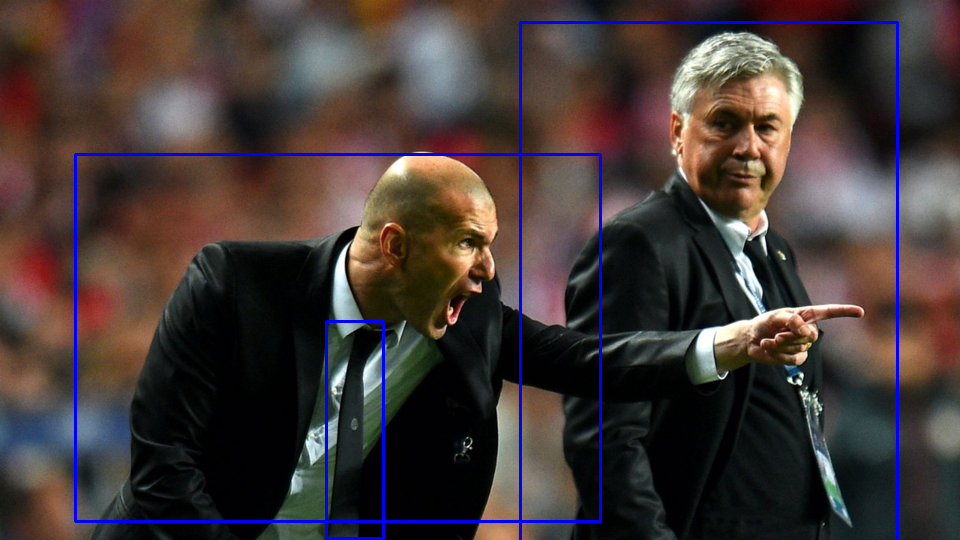

In [31]:
# ham tahminlerin elde
predictions_int8 = execute_model(model_quantized.inner_model, img_original)

predictions_int8_processed = postprocessing(list(predictions_int8), model_original)

conf_thres=0.15     # confidence threshold
iou_thres=0.25
classes=None        # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False
max_det=1000 
predictions_float_nms = non_max_suppression(predictions_int8_processed, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

img_temp1 = draw_bbox(img_original, predictions_float_nms[0])
Image.fromarray(img_temp1)

## 8. Modelin Hedef Platform İçin Derlenmesi 

Derleme için gerekli Vitis-AI modüllerinin dahil edilmesi:

In [32]:
from vaic.xcompiler_interface import xcompiler
import json

Derleme için gerekli konfigürasyon değişkenleri:

In [33]:
xmodel_path = "/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_quantized/DetectMultiBackend_int.xmodel"
arch_name = "DPUCZDX8G"
target_name = "KV260"
path_arch = f"/opt/vitis_ai/compiler/arch/{arch_name}/{target_name}/arch.json"
net_name = "YoloV5s_workshop"
output_dir_name = "model_compiled"

Derleme işlemi için kod adımları:

In [34]:
# define compiler parameters dictionary
compiler_params = {
	'parser': 'xir',
	'xmodel': str(xmodel_path),
	'net_name': net_name,
	'output_dir': 'Vitis-AI-Experiment/'+str(output_dir_name)
        }

# read arch fingerprint using arch.json
with open(path_arch) as json_data:
	if json_data: arch_data = json.load(json_data)

# add arch fingerprint to parameters dictionary
if arch_data and 'target' in arch_data:
	compiler_params['target'] = arch_data['target']
elif arch_data and 'fingerprint' in arch_data:
	compiler_params['fingerprint'] = arch_data['fingerprint']

# execute compiling process
xcompiler(compiler_params).compile()

[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: DetectMultiBackend, with op num: 448
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 5, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_compiled/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_compiled/YoloV5s_workshop.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is ec8faf3d41447ff704114b95c2823453, and has been saved to "/workspace/DEV/models/Demo1_AI_Solution_Development_with_VitisAI/yolov5/Vitis-AI-Experiment/model_compiled/md5sum.txt"
